# Film reviews classification (positive/negative)

## The data consists of 2000 film reviews, with an associated target of 'pos' or 'neg' for each one, respresenting the sentiment shown towards the film. Three ML models are trained and tuned to classify reviews as 'positive' or 'negative'.

In [1]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
import warnings
# Warnings only ignored in final notebook for ease of use
warnings.filterwarnings('ignore')

## Load in data

In [2]:
df = pd.read_csv('../DATA/moviereviews.csv')

In [3]:
df

,label,review
0,neg,how do films like mouse hunt get into theatres...
1,neg,some talented actresses are blessed with a dem...
2,pos,this has been an extraordinary year for austra...
3,pos,according to hollywood movies made in last few...
4,neg,my first press screening of 1998 and already i...
...,...,...
1995,pos,"i like movies with albert brooks , and i reall..."
1996,pos,it might surprise some to know that joel and e...
1997,pos,the verdict : spine-chilling drama from horror...
1998,pos,i want to correct what i wrote in a former ret...


## Check for and remove missing values (NaN values)

In [4]:
df.isna().sum()

label      0
review    35
dtype: int64

In [5]:
df.dropna(axis=0, inplace=True)
df

,label,review
0,neg,how do films like mouse hunt get into theatres...
1,neg,some talented actresses are blessed with a dem...
2,pos,this has been an extraordinary year for austra...
3,pos,according to hollywood movies made in last few...
4,neg,my first press screening of 1998 and already i...
...,...,...
1995,pos,"i like movies with albert brooks , and i reall..."
1996,pos,it might surprise some to know that joel and e...
1997,pos,the verdict : spine-chilling drama from horror...
1998,pos,i want to correct what i wrote in a former ret...


## Check for and remove strings of whitespace

In [6]:
df[df['review'].str.isspace()]

,label,review
57,neg,
71,pos,
147,pos,
151,pos,
283,pos,
307,pos,
313,neg,
323,pos,
343,pos,
351,neg,


In [7]:
df = df[~df['review'].str.isspace()]

## Value counts per label

In [8]:
df.label.value_counts()

neg    969
pos    969
Name: label, dtype: int64

## EDA on Bag of Words

In [9]:
count = CountVectorizer(analyzer='word', stop_words='english')
matrix = count.fit_transform(df.review)

In [10]:
count.get_feature_names_out()

array(['00', '000', '0009f', ..., 'zwigoff', 'zycie', 'zzzzzzz'],
      dtype=object)

In [11]:
matrix_neg = count.fit_transform(df[df['label'] == 'pos']['review'])
matrix_neg.toarray().shape
pd.Series(data=matrix_neg.toarray().sum(axis=0), index=count.get_feature_names_out()).sort_values(ascending=False).head(10)

film          5002
movie         2389
like          1721
just          1273
story         1199
good          1193
time          1175
character     1037
life          1032
characters     957
dtype: int64

In [12]:
matrix_pos = count.fit_transform(df[df['label'] == 'neg']['review'])
matrix_pos.toarray().shape
pd.Series(data=matrix_pos.toarray().sum(axis=0), index=count.get_feature_names_out()).sort_values(ascending=False).head(10)

film         4063
movie        3131
like         1808
just         1480
time         1127
good         1117
bad           997
character     926
story         908
plot          888
dtype: int64

## Training and Data

## Multinomial Naive Bayes'

In [13]:
X = df['review']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

In [14]:
steps = [('tfidf', TfidfVectorizer()), ('mb', MultinomialNB())]

pipe = Pipeline(steps=steps)

In [15]:
params = {
    'mb__alpha': [0, 1, 2, 5, 10]
}

grid_cv = GridSearchCV(pipe, param_grid=params)
grid_cv.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('mb', MultinomialNB())]),
             param_grid={'mb__alpha': [0, 1, 2, 5, 10]})

## Naive Bayes' Results

In [16]:
grid_cv.best_estimator_

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('mb', MultinomialNB(alpha=1))])

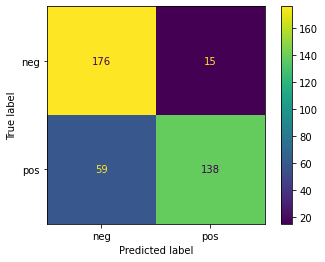

In [17]:
preds = grid_cv.predict(X_test)
ConfusionMatrixDisplay.from_predictions(y_test, preds)

In [18]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

         neg       0.75      0.92      0.83       191
         pos       0.90      0.70      0.79       197

    accuracy                           0.81       388
   macro avg       0.83      0.81      0.81       388
weighted avg       0.83      0.81      0.81       388



## Logistic regression

In [19]:
steps = [('tfidf', TfidfVectorizer()), ('log_model', LogisticRegression())]
pipe = Pipeline(steps=steps)

params = {
    'log_model__penalty': ['elastic_net', 'none'],
    'log_model__C': [0.001, 0.01, 0.1, 0.2, 0.5, 1],
    'log_model__l1_ratio': [0, 0.01, 0.1, 0.2, 0.5, 0.9, 1]
}

grid_cv = GridSearchCV(pipe, param_grid=params)

grid_cv.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('log_model', LogisticRegression())]),
             param_grid={'log_model__C': [0.001, 0.01, 0.1, 0.2, 0.5, 1],
                         'log_model__l1_ratio': [0, 0.01, 0.1, 0.2, 0.5, 0.9,
                                                 1],
                         'log_model__penalty': ['elastic_net', 'none']})

## Logistic regression results

In [20]:
grid_cv.best_estimator_

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('log_model',
                 LogisticRegression(C=0.001, l1_ratio=0, penalty='none'))])

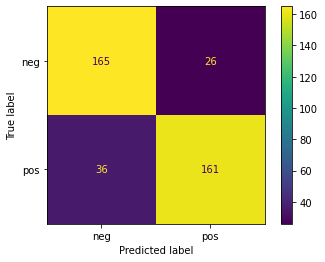

In [21]:
preds = grid_cv.predict(X_test)
ConfusionMatrixDisplay.from_predictions(y_test, preds)

In [22]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

         neg       0.82      0.86      0.84       191
         pos       0.86      0.82      0.84       197

    accuracy                           0.84       388
   macro avg       0.84      0.84      0.84       388
weighted avg       0.84      0.84      0.84       388



## Linear support vector classifier

In [23]:
steps = [('tfidf', TfidfVectorizer()), ('svc', LinearSVC(max_iter=2000))]
pipe = Pipeline(steps=steps)

params = {
    'svc__penalty': ['l1', 'l2'],
    'svc__C': [0.1, 0.2, 0.5, 1, 2, 5, 10],
    'svc__loss': ['hinge', 'squared_hinge']
}

grid_cv = GridSearchCV(pipe, param_grid=params)

grid_cv.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('svc', LinearSVC(max_iter=2000))]),
             param_grid={'svc__C': [0.1, 0.2, 0.5, 1, 2, 5, 10],
                         'svc__loss': ['hinge', 'squared_hinge'],
                         'svc__penalty': ['l1', 'l2']})

## Support vector classifier results

In [24]:
grid_cv.best_estimator_

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('svc', LinearSVC(C=2, max_iter=2000))])

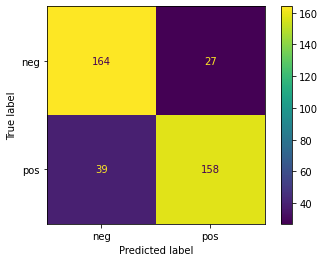

In [25]:
preds = grid_cv.predict(X_test)
ConfusionMatrixDisplay.from_predictions(y_test, preds)

In [26]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

         neg       0.81      0.86      0.83       191
         pos       0.85      0.80      0.83       197

    accuracy                           0.83       388
   macro avg       0.83      0.83      0.83       388
weighted avg       0.83      0.83      0.83       388



## Commentary

The results of all three models are very similar. Naive Bayes' seems to have performed the worst on average, although there are fewer adjustable parameters using this model compared to logistic regression and SVC.

Interestingly, quite a high 'C' value achieves the best results when fitting the SVC, implying that this dataset is not particularly prone to overfitting with the SVC. However, quite a small value of 'C' is optimal when fitting using logistic regression.

Given this is a simple analysis of the data, the initial results are promising for the three models, with an accuracy of at least 80%, similar precision and recall scores.

My recommendation would be to continue tuning the SVC and logistic regression models, due to the higher number of hyperparameters that can be tuned for these two models.